In [1]:
import tensorflow as tf
from tensorflow import reshape
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
#from data import load_image_h5
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import h5py
#import datetime
print(tf.__version__)

2.2.0


In [2]:
hf = h5py.File('xy-Mg22.h5', 'r')

In [3]:
image_width, image_length, image_channels = 128, 128, 3
image_shape = (128,128,3)

In [4]:
data = hf['features']
label = hf['targets']

In [5]:
data.shape

(2000, 128, 128)

In [6]:
train_data = data[0:1600]  # can use train test split function from skilearn for this task 
test_data = data[1601:2000]
train_label = label[0:1600]
test_label = label[1601:2000]

In [7]:
from numpy import expand_dims
train_data=expand_dims(train_data, axis=3)
train_data.shape

(1600, 128, 128, 1)

In [8]:
train_data = np.concatenate((train_data,)*3, axis=-1)
train_data.shape

(1600, 128, 128, 3)

In [9]:
test_data=expand_dims(test_data, axis=3)
test_data.shape

(399, 128, 128, 1)

In [10]:
test_data=np.concatenate((test_data,)*3, axis=-1)
test_data.shape

(399, 128, 128, 3)

In [11]:
train_data = train_data.reshape((len(train_data), image_width, image_length, image_channels))

In [12]:
train_data = train_data/255.0
test_data = test_data/255.0

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [14]:
vgg16_model = tf.keras.applications.VGG16(input_shape=image_shape, include_top=False, weights='imagenet')

In [15]:
vgg16_model.trainable=True

In [16]:
CNN_model = tf.keras.Sequential()
CNN_model.add(vgg16_model)
CNN_model.add(layers.Flatten())
CNN_model.add(layers.Dense(175, activation='relu'))
CNN_model.add(layers.Dropout(0.1))
CNN_model.add(layers.Dense(175, activation='relu'))
CNN_model.add(layers.Dropout(0.1))
CNN_model.add(layers.Dense(3, activation='softmax'))

CNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0000001),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])

In [17]:
CNN_history = CNN_model.fit(train_data, train_label, epochs=100,
                           batch_size=32,
                           shuffle=True,
                           #callbacks = [callback],
                           validation_split=0.3)

Epoch 1/100
35/35 [==============================] - 167s 5s/step - loss: 1.0182 - accuracy: 0.4982 - val_loss: 1.0003 - val_accuracy: 0.4938
Epoch 2/100
35/35 [==============================] - 167s 5s/step - loss: 0.9936 - accuracy: 0.5009 - val_loss: 0.9790 - val_accuracy: 0.4938
Epoch 3/100
35/35 [==============================] - 176s 5s/step - loss: 0.9747 - accuracy: 0.5045 - val_loss: 0.9598 - val_accuracy: 0.4917
Epoch 4/100
35/35 [==============================] - 178s 5s/step - loss: 0.9674 - accuracy: 0.4902 - val_loss: 0.9425 - val_accuracy: 0.4938
Epoch 5/100
35/35 [==============================] - 182s 5s/step - loss: 0.9312 - accuracy: 0.5134 - val_loss: 0.9259 - val_accuracy: 0.4938
Epoch 6/100
35/35 [==============================] - 187s 5s/step - loss: 0.9372 - accuracy: 0.4955 - val_loss: 0.9102 - val_accuracy: 0.4917
Epoch 7/100
35/35 [==============================] - 186s 5s/step - loss: 0.9108 - accuracy: 0.5277 - val_loss: 0.8952 - val_accuracy: 0.4938
Epoch 

35/35 [==============================] - 377s 11s/step - loss: 0.7256 - accuracy: 0.5223 - val_loss: 0.7171 - val_accuracy: 0.4979
Epoch 59/100
35/35 [==============================] - 1915s 55s/step - loss: 0.7112 - accuracy: 0.5304 - val_loss: 0.7167 - val_accuracy: 0.5208
Epoch 60/100
35/35 [==============================] - 163s 5s/step - loss: 0.7147 - accuracy: 0.5571 - val_loss: 0.7164 - val_accuracy: 0.5167
Epoch 61/100
35/35 [==============================] - 158s 5s/step - loss: 0.7175 - accuracy: 0.5250 - val_loss: 0.7163 - val_accuracy: 0.5104
Epoch 62/100
35/35 [==============================] - 158s 5s/step - loss: 0.7303 - accuracy: 0.5000 - val_loss: 0.7162 - val_accuracy: 0.5104
Epoch 63/100
35/35 [==============================] - 158s 5s/step - loss: 0.7073 - accuracy: 0.5571 - val_loss: 0.7159 - val_accuracy: 0.5146
Epoch 64/100
35/35 [==============================] - 303s 9s/step - loss: 0.7221 - accuracy: 0.5170 - val_loss: 0.7158 - val_accuracy: 0.5125
Epoch 65/

In [18]:
result = CNN_model.evaluate(test_data, test_label, verbose=2)

13/13 - 13s - loss: 0.6986 - accuracy: 0.5263


In [19]:
predictions = np.argmax(CNN_model.predict(test_data[:]),axis=1)

In [20]:
print(classification_report(test_label, predictions))

              precision    recall  f1-score   support

           1       0.52      0.81      0.63       200
           2       0.56      0.24      0.34       199

    accuracy                           0.53       399
   macro avg       0.54      0.53      0.48       399
weighted avg       0.54      0.53      0.48       399



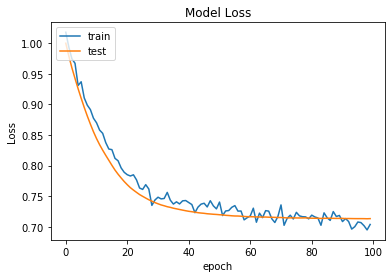

In [21]:
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model Loss')
#plt.yscale("log")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix
import itertools

In [24]:
cm = confusion_matrix(test_label, predictions)

In [25]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         include_values=True,
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() /2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

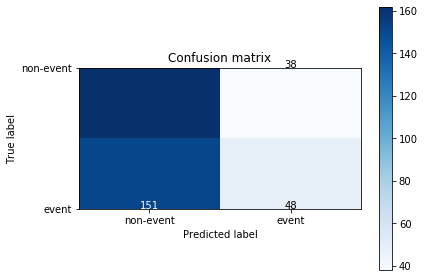

In [27]:
cm_plot_labels = ['non-event', 'event'] # 1 being non event and 2 being event
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix')